In this notebook we will explore the dataset

In [2]:
# jupyter utils
from IPython.display import display

import pandas as pd
import numpy as np

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.express as px
init_notebook_mode(connected=True)

# local modules
from utils import load_dataset

%matplotlib inline

In [3]:
def load_and_preprocess():
    df = pd.read_csv('data/train.csv')
    # change age column from float to int
    df['SubjectAge'] = df['SubjectAge'].astype('int16')
    df['InterventionDateTime'] = pd.to_datetime(df['InterventionDateTime'],infer_datetime_format=True)
    return df
#df = load_and_preprocess()
df = load_dataset()

In [4]:
display(df.head(3))
display(df.shape)

,VehicleSearchedIndicator,ContrabandIndicator,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
0,False,False,New Haven,10/01/2013 12:00:00 AM,NEW HAVEN,V,262,True,N,Stop Sign,31.0,H,W,M,True
1,False,False,State Police,10/01/2013 12:00:00 AM,WILLINGTON,V,1000002715,False,N,Other,29.0,M,W,M,False
2,False,False,Plymouth,10/01/2013 12:00:00 AM,Terryville,V,21,True,N,Speed Related,18.0,N,W,M,True


(2473643, 15)

# TARGET VARIABLE

In [5]:
# plotly bar plot
# of ContrabandIndicator column 
# of dataframe

data = [
    go.Bar(
        x = df.ContrabandIndicator.index,
        y = df.ContrabandIndicator.values,
        orientation='v'
)

layout = go.Layout(
    height=800,
    title=f'Contraband found distribution',
    hovermode='closest',
    xaxis=dict(title='Frequency (%)', ticklen=5, zeroline=False, gridwidth=2, domain=[0.1, 1]),
    yaxis=dict(title='Departments', ticklen=5, gridwidth=2),
    showlegend=False
)



SyntaxError: invalid syntax (<ipython-input-5-be218472ff26>, line 12)

# POLICE DEPARTMENTS

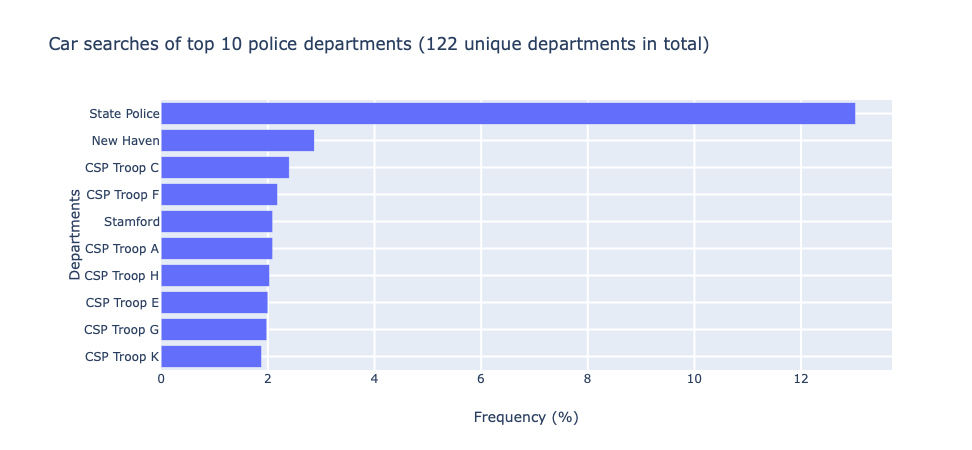

In [5]:
departments_freq = round(df['Department Name'].value_counts(normalize=True) * 100,2).sort_values(ascending=True).tail(10)
data = [
    go.Bar(
        y=departments_freq.index,
        x=departments_freq,
        orientation='h',
    )]
layout = go.Layout(
    height=800,
    title=f'Car searches of top {departments_freq.size} police departments ({df["Department Name"].nunique()} unique departments in total)',
    hovermode='closest',
    xaxis=dict(title='Frequency (%)', ticklen=5, zeroline=False, gridwidth=2, domain=[0.1, 1]),
    yaxis=dict(title='Departments', ticklen=5, gridwidth=2),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

**State Police** does the most searches by a large margin.

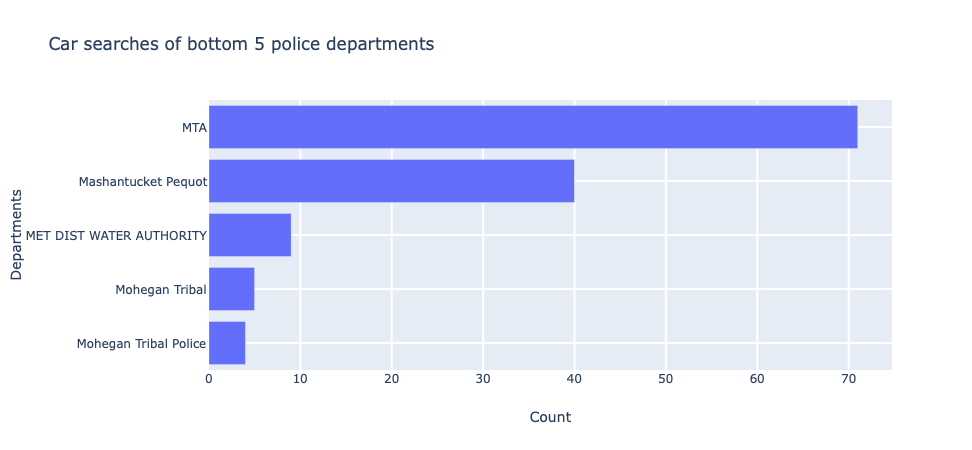

In [272]:
departments_freq = df['Department Name'].value_counts(normalize=False).sort_values(ascending=True).head(5)
data = [
    go.Bar(
        y=departments_freq.index,
        x=departments_freq,
        orientation='h'
    )]
layout = go.Layout(
    height=800,
    title=f'Car searches of bottom {departments_freq.size} police departments',
    hovermode='closest',
    xaxis=dict(title='Count', ticklen=5, zeroline=False, gridwidth=2, domain=[0.1, 1]),
    yaxis=dict(title='Departments', ticklen=5, gridwidth=2),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

Some departments have a really low number of searches. These departments will be very difficult to follow the requirements requested by the client, namely:
- A minimum 50% success rate for searches;
- No police sub-department should have a discrepancy bigger than 5% in success rate.

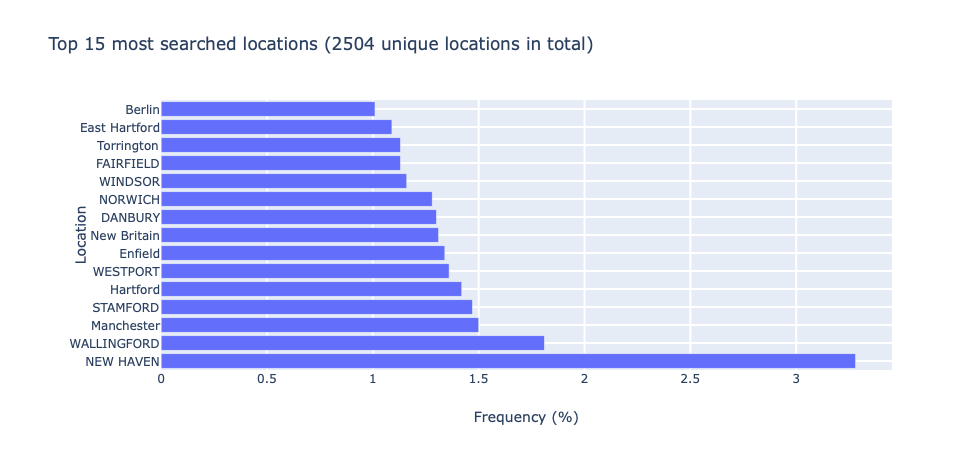

In [274]:
location_name = round(df['InterventionLocationName'].value_counts(normalize=True) * 100,2).sort_values(ascending=False).head(15)
data = [
    go.Bar(
        y=location_name.index,
        x=location_name,
        orientation='h'
    )]
layout = go.Layout(
    height=800,
    title=f'Top {location_name.size} most searched locations ({df["InterventionLocationName"].nunique()} unique locations in total)',
    hovermode='closest',
    xaxis=dict(title='Frequency (%)', ticklen=5, zeroline=False, gridwidth=2, domain=[0.1, 1]),
    yaxis=dict(title='Location', ticklen=5, gridwidth=2),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

Most searches happen in **New Haven** and there are a lot of locations overall

In [275]:
print("Was contraband found when the cars weren\'t searched?")
mask_not_searched = df.VehicleSearchedIndicator == False
df[mask_not_searched].ContrabandIndicator.value_counts().rename(index={False:'Not found',True:'Found!'})

Was contraband found when the cars weren't searched?


Not found    2394077
Found!          2823
Name: ContrabandIndicator, dtype: int64

In very few cases cases it seems that the police found illegal activity happening without performing an official search. Perhaps those were scenarios where it was too obvious that an illegal activity was going on without having to perform a search.

In [276]:
print("Contraband distribution")
(df.ContrabandIndicator.value_counts(normalize=True).rename(index={False:'Not found',True:'Found!'})*100).apply(lambda x: str(round(x,2))+"%")

Contraband distribution


Not found    98.85%
Found!        1.15%
Name: ContrabandIndicator, dtype: object

We are dealing with a very unbalanced target variable.

# Success rate of the searches

## By Department

In [212]:
display(df.head(3))
display(df.shape)

,VehicleSearchedIndicator,ContrabandIndicator,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
0,False,False,New Haven,2013-10-01,NEW HAVEN,V,262,True,N,Stop Sign,31,H,W,M,True
1,False,False,State Police,2013-10-01,WILLINGTON,V,1000002715,False,N,Other,29,M,W,M,False
2,False,False,Plymouth,2013-10-01,Terryville,V,21,True,N,Speed Related,18,N,W,M,True


(2473643, 15)

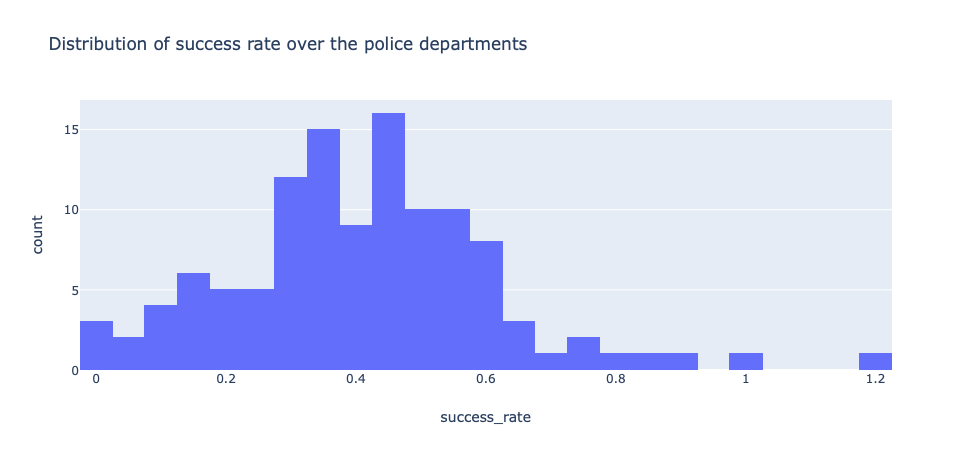

In [279]:
#preprocess
department_searches = df.groupby("Department Name").VehicleSearchedIndicator.sum().rename('searches')
department_contraband_found = df.groupby("Department Name").ContrabandIndicator.sum().rename('contraband_found')
department_success_rate = department_contraband_found.div(department_searches).sort_values(ascending=False).rename('success_rate')

# remove outlier
department_success_rate = department_success_rate.drop('ECSU',axis='index')

#plot
fig = px.histogram(department_success_rate.to_frame(),x='success_rate',nbins=40,title='Distribution of success rate over the police departments')
fig.show()

There's a lot of spread on the rate of finding contraband for each search

# Perceber a relação das razões para para o veículo com a autoridade para fazer busca no veículo

In [280]:
display(df.head(3))
display(df.shape)

,VehicleSearchedIndicator,ContrabandIndicator,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
0,False,False,New Haven,2013-10-01,NEW HAVEN,V,262,True,N,Stop Sign,31,H,W,M,True
1,False,False,State Police,2013-10-01,WILLINGTON,V,1000002715,False,N,Other,29,M,W,M,False
2,False,False,Plymouth,2013-10-01,Terryville,V,21,True,N,Speed Related,18,N,W,M,True


(2473643, 15)

In [306]:
auth_to_join_df = pd.Series(index=df.SearchAuthorizationCode.unique(),name='placeholder').fillna(0).to_frame()
auth_to_join_df

,placeholder
N,0.0
O,0.0
I,0.0
C,0.0
NaN,0.0


In [363]:
Z = df_no_intervention_nulls.SearchAuthorizationCode.unique()

In [364]:
[x for x in Z if x == x]

['N', 'O', 'I', 'C']

In [355]:
auth_codes = df_no_intervention_nulls.SearchAuthorizationCode.unique()
auth_codes = [code for code in auth_codes if code]
auth_to_join_df = pd.Series(index=auth_codes,name='placeholder').fillna(0)
auth_to_join_df

N      0.0
O      0.0
I      0.0
C      0.0
NaN    0.0
Name: placeholder, dtype: float64

In [367]:
# queremos perceber a distribuição da autoridade dentro das 3 categorias 
# das razões para ter parado o veículo: Investigation, Violation, Equipment.


auth_codes = df.SearchAuthorizationCode.unique()
auth_codes = [code for code in auth_codes if code == code] # remove nan
auth_to_join_df = pd.Series(index=auth_codes,name='placeholder').fillna(0)
intervention_names = df['InterventionReasonCode'].unique()

['N', 'O', 'I', 'C']

In [369]:
df['InterventionReasonCode'].unique()

array(['V', 'E', 'I', nan, 'no'], dtype=object)

In [373]:
# queremos perceber a distribuição da autoridade dentro das 3 categorias 
# das razões para ter parado o veículo: Investigation, Violation, Equipment.

# unique auth_codes
auth_codes = df.SearchAuthorizationCode.unique()
auth_codes = [code for code in auth_codes if code == code] # remove nan
# unique intervention codes
intervention_names = df['InterventionReasonCode'].unique()
intervention_names = [x for x in intervention_names if x == x] # remove nans
# base df to join intervention values
auth_to_join_df = pd.Series(index=intervention_names,name='placeholder').fillna(0).to_frame()
auth_to_join_df

,placeholder
V,0.0
E,0.0
I,0.0
no,0.0


In [377]:
figure_data

[Bar({
     'name': 'V', 'x': ['N', 'O', 'I', 'C'], 'y': array([2109851,   36199,   12725,   20516])
 }), Bar({
     'name': 'E', 'x': ['N', 'O', 'I', 'C'], 'y': array([231020,   6804,   1929,   5037])
 }), Bar({
     'name': 'I', 'x': ['N', 'O', 'I', 'C'], 'y': array([43429,  2431,  1368,  1775])
 }), Bar({
     'name': 'no', 'x': ['N', 'O', 'I', 'C'], 'y': array([ 3., nan, nan, nan])
 })]

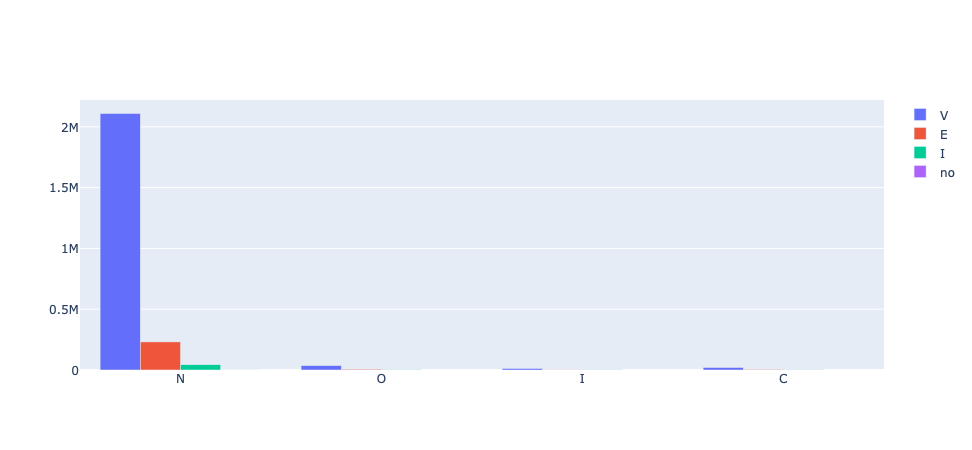

In [376]:
# queremos perceber a distribuição da autoridade dentro das 3 categorias 
# das razões para ter parado o veículo: Investigation, Violation, Equipment.

# unique auth_codes
auth_codes = df.SearchAuthorizationCode.unique()
auth_codes = [code for code in auth_codes if code == code] # remove nan
# unique intervention codes
intervention_names = df['InterventionReasonCode'].unique()
intervention_names = [x for x in intervention_names if x == x] # remove nans
# base df to join intervention values
auth_to_join_df = pd.Series(index=auth_codes,name='placeholder').fillna(0).to_frame()

figure_data = []
for intervention in intervention_names:
    
    intervention_data = df.where(df.InterventionReasonCode == intervention).dropna()
    auth_data = intervention_data.SearchAuthorizationCode.value_counts().rename('data').to_frame()
    # join with auth_series in case one or more labels don't exist in this subgroup
    full_auth_data = auth_to_join_df.join(auth_data,how='left')
    bar = go.Bar(name=intervention,x=auth_codes, y=full_auth_data.data)
    figure_data.append(bar)
    
fig = go.Figure(data=figure_data)
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

